In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-05-26 15:07:50.190810: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 15:07:50.190906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 15:07:50.339870: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# current dir
!pwd

# print tree structure of the parent directory. Now we are getting somewhere, full tree of files that you care for.
!tree .. -d

/kaggle/working
..
|-- input
|   `-- fer2013pluscleanedaugmballanced1
|       |-- test
|       |   |-- Anger
|       |   |-- Disgust
|       |   |-- Fear
|       |   |-- Happy
|       |   |-- Neutral
|       |   |-- Sad
|       |   `-- Surprise
|       `-- train
|           |-- Anger
|           |-- Disgust
|           |-- Fear
|           |-- Happy
|           |-- Neutral
|           |-- Sad
|           `-- Surprise
|-- lib
|   `-- kaggle
`-- working

21 directories


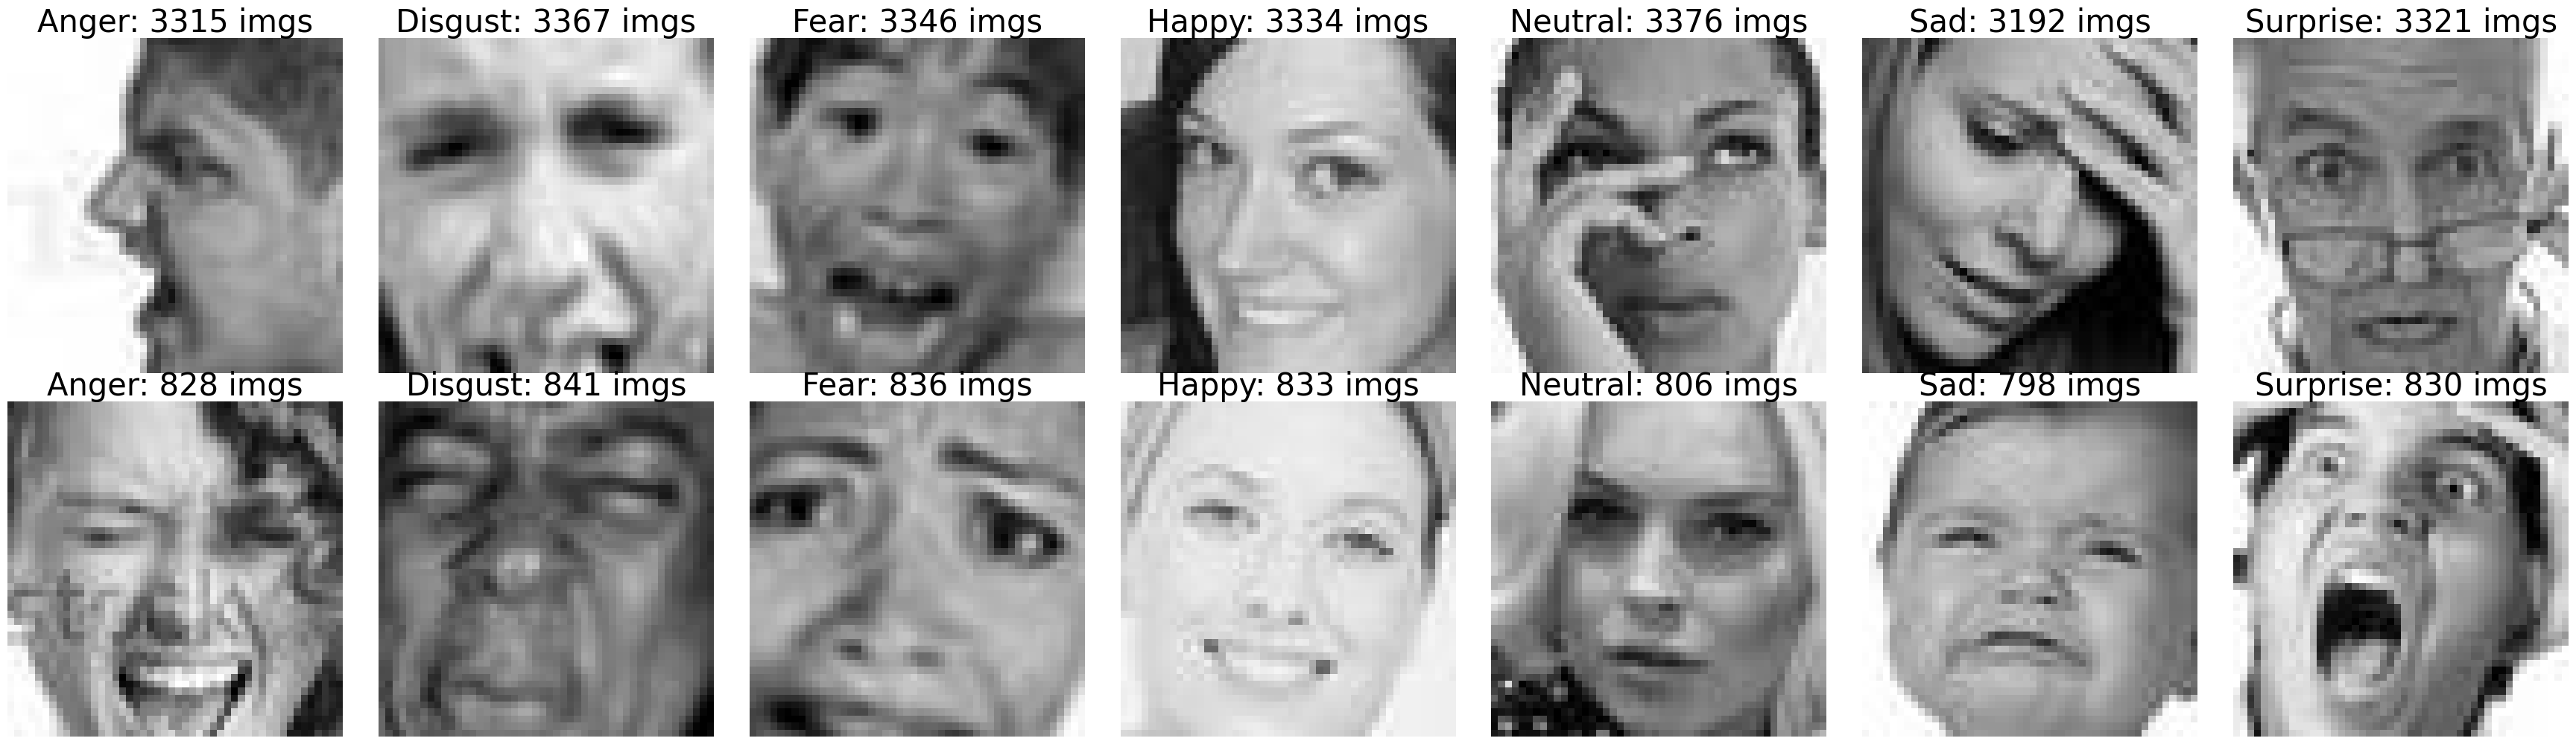

In [3]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img

def preview_datasets(train_dir, test_dir, samples_per_class=3):
    train_classes = sorted(os.listdir(train_dir))
    val_classes = sorted(os.listdir(test_dir))

    total_classes = len(train_classes) # num of classes
    fig, axes = plt.subplots(nrows=2, ncols=max(1, total_classes) * samples_per_class, figsize=(5 * total_classes * samples_per_class, 10))

    # plot images
    def plot_images_for_dataset(dataset_dir, row, class_names):
        for i, cls in enumerate(class_names):
            cls_dir = os.path.join(dataset_dir, cls)
            images = os.listdir(cls_dir)
            selected_images = np.random.choice(images, min(samples_per_class, len(images)), replace=False)

            for j, image in enumerate(selected_images):
                idx = i * samples_per_class + j
                img_path = os.path.join(cls_dir, image)
                img = load_img(img_path)
                ax = axes[row, idx]
                ax.imshow(img)
                ax.set_title(f'{cls}: {len(images)} imgs', fontsize = 30)
                ax.axis('off')

    # plot training images
    plot_images_for_dataset(train_dir, 0, train_classes)
    # plot testing images
    plot_images_for_dataset(test_dir, 1, val_classes)

    plt.tight_layout()
    plt.show()

train_dir = '/kaggle/input/fer2013pluscleanedaugmballanced1/train'
test_dir = '/kaggle/input/fer2013pluscleanedaugmballanced1/test'

preview_datasets(train_dir, test_dir, samples_per_class=1)

## Generate CSV Files

KFold Cross Validation can be cumbersome if we are using flow_from_directory method, so we opt for flow_from_dataframe instead, which requires a dataframe (CSV).

In [4]:
from sklearn.utils import shuffle

def create_csv(input_dir, output_csv_path):
    data = [] #to store the file names and its labels
    
    #     list all the subdirs
    for label, subdir_name in enumerate(sorted(os.listdir(input_dir))):
        subdir_path = os.path.join(input_dir, subdir_name)
        if os.path.isdir(subdir_path): # its a legit directory
            for filename in os.listdir(subdir_path):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                    file_path = os.path.join(subdir_path, filename)
                    data.append((file_path, f'{label}'))

        df = pd.DataFrame(data, columns = ['filename', 'label'])
        df['label'] = df['label'].astype(str)
        df = shuffle(df, random_state = 42) # shuffle rows so the classes are not grouped
        df.to_csv(output_csv_path, index = False)
              
create_csv(train_dir, '/kaggle/working/train.csv')
create_csv(test_dir, '/kaggle/working/test.csv')

In [5]:
train_df = pd.read_csv('/kaggle/working/train.csv', dtype={'label': str})
print(train_df.head(5))
print(train_df.sample(5))

                                            filename label
0  /kaggle/input/fer2013pluscleanedaugmballanced1...     0
1  /kaggle/input/fer2013pluscleanedaugmballanced1...     1
2  /kaggle/input/fer2013pluscleanedaugmballanced1...     2
3  /kaggle/input/fer2013pluscleanedaugmballanced1...     3
4  /kaggle/input/fer2013pluscleanedaugmballanced1...     5
                                                filename label
7460   /kaggle/input/fer2013pluscleanedaugmballanced1...     1
3728   /kaggle/input/fer2013pluscleanedaugmballanced1...     1
22282  /kaggle/input/fer2013pluscleanedaugmballanced1...     0
427    /kaggle/input/fer2013pluscleanedaugmballanced1...     0
18020  /kaggle/input/fer2013pluscleanedaugmballanced1...     6


## Model
For more Keras layers for transfer learning: https://keras.io/api/applications/ 

We can build the top layers using Functional or Sequential API. But imported layers from link above are Functional by default, I recommend bulding the top layers with Functional API so it does not raise error when we call load_model().

For more info about Sequential and Fucntional: https://medium.com/analytics-vidhya/keras-model-sequential-api-vs-functional-api-fc1439a6fb10

/tmp/ipykernel_34/1409716179.py:18: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenetmodel = MobileNet(input_shape = (48, 48, 3), weights = 'imagenet', include_top = False)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 24, 24, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 24, 24, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 24, 24, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 24, 24, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 12, 12, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 12, 12, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 12, 12, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 12, 12, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 1, 1, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 4,884,167 (18.63 MB)

 Trainable params: 4,856,839 (18.53 MB)

 Non-trainable params: 27,328 (106.75 KB)

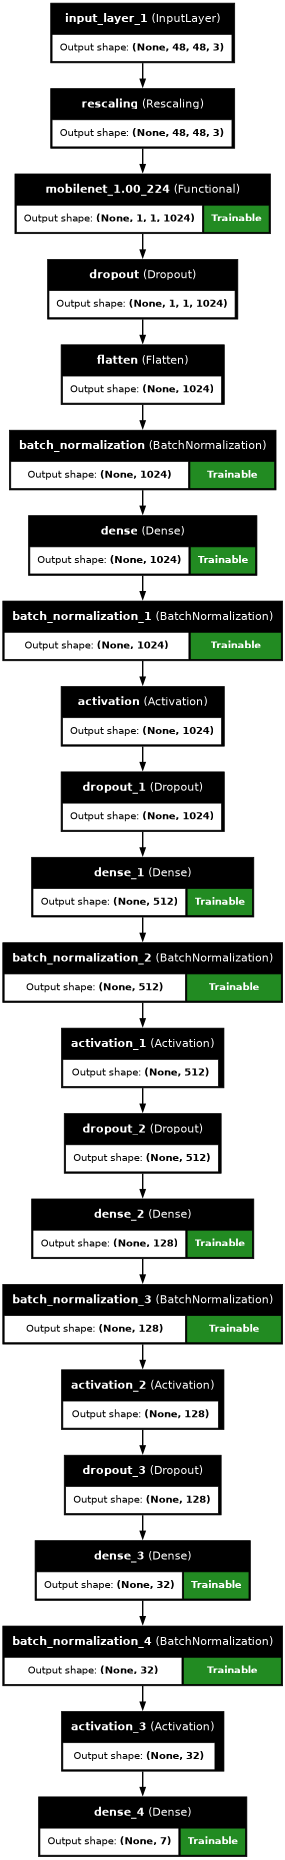

In [6]:
# model

from tensorflow.keras.applications import MobileNetV2, MobileNet
from tensorflow.keras.layers import Input, Rescaling, BatchNormalization, Dense, Flatten, Dropout, Activation, GaussianNoise, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import f1_score, precision_score, recall_score
from keras.callbacks import Callback
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence

initial_learning_rate = 1e-3
epochs = 30

mobilenetmodel = MobileNet(input_shape = (48, 48, 3), weights = 'imagenet', include_top = False)
for layer in mobilenetmodel.layers[:]:
    layer.trainable = True
    
mobilenetmodel.summary()
tf.keras.utils.plot_model(mobilenetmodel, 
                          show_shapes = True, 
                          dpi = 50,
                          show_trainable = True,
                          show_layer_names = True,
                          to_file = '/kaggle/working/mobilenet.png'
                         )

def get_model():
    
    # try using Functional instead of Sequential
    img_input = Input(shape = (48, 48, 3))
    x = Rescaling(1./255)(img_input)
    x = mobilenetmodel(x)

    # build our own top layers
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(1024, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(512, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(128, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(32, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    outputs = Dense(7, activation='softmax')(x)
    
    model = Model(inputs = img_input, outputs = outputs)

    # compile
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = initial_learning_rate),
                loss = 'categorical_crossentropy',
                metrics = ['acc', Precision(), Recall()])

    return model

model = get_model()
model.summary()

tf.keras.utils.plot_model(model, 
                          show_shapes = True, 
                          dpi = 50,
                          show_trainable = True,
                          show_layer_names = True,
                          to_file = '/kaggle/working/whole_model.png'
                         )


In [8]:
# callbacks

from sklearn.metrics import f1_score, precision_score, recall_score
from keras.callbacks import Callback

# 1. ReduceLROnPlateau
lrd = ReduceLROnPlateau(monitor = 'val_acc', factor = 0.5, patience = 7, min_lr = 1e-7, verbose = 1)

# 2. ModelCheckpoint
model_checkpoint = ModelCheckpoint('/kaggle/working/mobilenet_model.keras', 
                                   save_best_only=True,
#                                    save_weights_only=True, uncomment if saving in ".weights.h5"
                                   monitor = 'val_acc', 
                                   verbose = 1)

# 3. Early Stopping
early_stopping = EarlyStopping(monitor = 'val_acc', min_delta = 0.00005, patience = 11, verbose = 1, restore_best_weights = True)

In [9]:
from sklearn.model_selection import KFold

datagen = ImageDataGenerator(
    rescale = 1./255,
    # validation_split = 0.2, not needed. validation will be created using k splits
    rotation_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
    )

kfold = KFold(n_splits = 5, shuffle = True, random_state = 40)
fold_no = 1

all_train_acc = []
all_val_acc = []
all_train_loss = []
all_val_loss = []

for train_index, val_index in kfold.split(train_df):
    train_data = train_df.iloc[train_index]
    val_data = train_df.iloc[val_index]

    train_generator = datagen.flow_from_dataframe(
        train_data,
        directory = None, # directory — (str)Path to the directory which contains all the images. set this to None if your x_col contains absolute_paths pointing to each image files instead of just filenames.
        x_col = "filename",
        y_col = "label",
        class_mode = 'categorical',
        shuffle = True,
        target_size = (48, 48),
        batch_size=32
        )
    val_generator = datagen.flow_from_dataframe(
        val_data,
        directory = None, # directory — (str)Path to the directory which contains all the images. set this to None if your x_col contains absolute_paths pointing to each image files instead of just filenames.
        x_col = "filename",
        y_col = "label",
        class_mode = 'categorical',
        shuffle = True,
        target_size = (48, 48),
        batch_size=32
        )

    model = get_model()

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history=model.fit(train_generator,
                    epochs = epochs,
                    validation_data=val_generator,
                    callbacks=[lrd, 
                               model_checkpoint,
                               early_stopping
                               ],
                    verbose = 1)

    all_train_acc.append(history.history['acc'])
    all_val_acc.append(history.history['val_acc'])
    all_train_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])

    fold_no += 1

Found 18600 validated image filenames belonging to 7 classes.
Found 4651 validated image filenames belonging to 7 classes.
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/582 ━━━━━━━━━━━━━━━━━━━━ 6:21:24 39s/step - acc: 0.1250 - loss: 2.5567 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00

I0000 00:00:1716736181.647172     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716736181.695584     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 16/582 ━━━━━━━━━━━━━━━━━━━━ 13:38 1s/step - acc: 0.1366 - loss: 2.4082 - precision_1: 0.0866 - recall_1: 0.0115

W0000 00:00:1716736203.230999     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - acc: 0.1772 - loss: 2.0700 - precision_1: 0.2447 - recall_1: 0.0108

W0000 00:00:1716736287.039449     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_acc improved from -inf to 0.15459, saving model to /kaggle/working/mobilenet_model.keras


W0000 00:00:1716736310.387334     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


582/582 ━━━━━━━━━━━━━━━━━━━━ 169s 223ms/step - acc: 0.1773 - loss: 2.0696 - precision_1: 0.2453 - recall_1: 0.0108 - val_acc: 0.1546 - val_loss: 1.9913 - val_precision_1: 0.2963 - val_recall_1: 0.0017 - learning_rate: 0.0010
Epoch 2/30
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - acc: 0.3086 - loss: 1.6991 - precision_1: 0.6052 - recall_1: 0.0781
Epoch 2: val_acc improved from 0.15459 to 0.36852, saving model to /kaggle/working/mobilenet_model.keras
582/582 ━━━━━━━━━━━━━━━━━━━━ 43s 74ms/step - acc: 0.3087 - loss: 1.6988 - precision_1: 0.6054 - recall_1: 0.0782 - val_acc: 0.3685 - val_loss: 1.5784 - val_precision_1: 0.7556 - val_recall_1: 0.1456 - learning_rate: 0.0010
Epoch 3/30
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - acc: 0.4127 - loss: 1.4586 - precision_1: 0.7098 - recall_1: 0.1987
Epoch 3: val_acc did not improve from 0.36852
582/582 ━━━━━━━━━━━━━━━━━━━━ 44s 74ms/step - acc: 0.4127 - loss: 1.4586 - precision_1: 0.7098 - recall_1: 0.1987 - val_acc: 0.2808 - val_loss: 1.8229 - val

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  4/582 ━━━━━━━━━━━━━━━━━━━━ 30s 53ms/step - acc: 0.1673 - loss: 2.2646 - precision_2: 0.1723 - recall_2: 0.0150         

W0000 00:00:1716737622.433233     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.6601 - loss: 1.0729 - precision_2: 0.8219 - recall_2: 0.4808 

W0000 00:00:1716737682.516104     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_acc did not improve from 0.75231
582/582 ━━━━━━━━━━━━━━━━━━━━ 103s 122ms/step - acc: 0.6603 - loss: 1.0722 - precision_2: 0.8219 - recall_2: 0.4812 - val_acc: 0.7359 - val_loss: 0.7626 - val_precision_2: 0.7820 - val_recall_2: 0.6852 - learning_rate: 0.0010
Epoch 2/30


W0000 00:00:1716737693.256276     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - acc: 0.7564 - loss: 0.7524 - precision_2: 0.8190 - recall_2: 0.6822
Epoch 2: val_acc improved from 0.75231 to 0.75376, saving model to /kaggle/working/mobilenet_model.keras
582/582 ━━━━━━━━━━━━━━━━━━━━ 44s 75ms/step - acc: 0.7564 - loss: 0.7523 - precision_2: 0.8190 - recall_2: 0.6822 - val_acc: 0.7538 - val_loss: 0.6676 - val_precision_2: 0.8115 - val_recall_2: 0.6944 - learning_rate: 0.0010
Epoch 3/30
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - acc: 0.7500 - loss: 0.7306 - precision_2: 0.8194 - recall_2: 0.6837
Epoch 3: val_acc improved from 0.75376 to 0.77806, saving model to /kaggle/working/mobilenet_model.keras
582/582 ━━━━━━━━━━━━━━━━━━━━ 43s 74ms/step - acc: 0.7500 - loss: 0.7305 - precision_2: 0.8194 - recall_2: 0.6837 - val_acc: 0.7781 - val_loss: 0.6169 - val_precision_2: 0.8397 - val_recall_2: 0.7163 - learning_rate: 0.0010
Epoch 4/30
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - acc: 0.7618 - loss: 0.6986 - precision_2: 0.8258 - rec

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  4/582 ━━━━━━━━━━━━━━━━━━━━ 26s 46ms/step - acc: 0.2018 - loss: 2.3141 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 

W0000 00:00:1716739022.164360     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - acc: 0.7057 - loss: 0.9631 - precision_3: 0.8348 - recall_3: 0.5214

W0000 00:00:1716739077.025671     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_acc did not improve from 0.82516
582/582 ━━━━━━━━━━━━━━━━━━━━ 96s 110ms/step - acc: 0.7060 - loss: 0.9623 - precision_3: 0.8349 - recall_3: 0.5219 - val_acc: 0.8054 - val_loss: 0.5564 - val_precision_3: 0.8503 - val_recall_3: 0.7561 - learning_rate: 0.0010
Epoch 2/30


W0000 00:00:1716739086.238802     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - acc: 0.8080 - loss: 0.6090 - precision_3: 0.8543 - recall_3: 0.7560
Epoch 2: val_acc did not improve from 0.82516
582/582 ━━━━━━━━━━━━━━━━━━━━ 43s 74ms/step - acc: 0.8080 - loss: 0.6090 - precision_3: 0.8543 - recall_3: 0.7560 - val_acc: 0.8045 - val_loss: 0.5633 - val_precision_3: 0.8444 - val_recall_3: 0.7632 - learning_rate: 0.0010
Epoch 3/30
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - acc: 0.8177 - loss: 0.5652 - precision_3: 0.8581 - recall_3: 0.7767
Epoch 3: val_acc improved from 0.82516 to 0.83742, saving model to /kaggle/working/mobilenet_model.keras
582/582 ━━━━━━━━━━━━━━━━━━━━ 44s 75ms/step - acc: 0.8177 - loss: 0.5652 - precision_3: 0.8581 - recall_3: 0.7766 - val_acc: 0.8374 - val_loss: 0.4760 - val_precision_3: 0.8808 - val_recall_3: 0.7865 - learning_rate: 0.0010
Epoch 4/30
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - acc: 0.8096 - loss: 0.5782 - precision_3: 0.8488 - recall_3: 0.7679
Epoch 4: val_acc did not improve from 0.83742

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  4/582 ━━━━━━━━━━━━━━━━━━━━ 26s 46ms/step - acc: 0.1725 - loss: 2.2598 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 

W0000 00:00:1716740398.200138     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - acc: 0.7440 - loss: 0.8618 - precision_4: 0.8774 - recall_4: 0.5750

W0000 00:00:1716740450.414555     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_acc did not improve from 0.85376
582/582 ━━━━━━━━━━━━━━━━━━━━ 94s 107ms/step - acc: 0.7442 - loss: 0.8611 - precision_4: 0.8774 - recall_4: 0.5755 - val_acc: 0.8523 - val_loss: 0.4580 - val_precision_4: 0.8738 - val_recall_4: 0.8282 - learning_rate: 0.0010
Epoch 2/30


W0000 00:00:1716740460.285232     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - acc: 0.8321 - loss: 0.5388 - precision_4: 0.8662 - recall_4: 0.7909
Epoch 2: val_acc did not improve from 0.85376
582/582 ━━━━━━━━━━━━━━━━━━━━ 43s 73ms/step - acc: 0.8321 - loss: 0.5388 - precision_4: 0.8662 - recall_4: 0.7909 - val_acc: 0.8473 - val_loss: 0.4336 - val_precision_4: 0.8873 - val_recall_4: 0.8095 - learning_rate: 0.0010
Epoch 3/30
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - acc: 0.8454 - loss: 0.4876 - precision_4: 0.8745 - recall_4: 0.8153
Epoch 3: val_acc did not improve from 0.85376
582/582 ━━━━━━━━━━━━━━━━━━━━ 43s 74ms/step - acc: 0.8454 - loss: 0.4876 - precision_4: 0.8745 - recall_4: 0.8153 - val_acc: 0.8510 - val_loss: 0.4310 - val_precision_4: 0.8822 - val_recall_4: 0.8215 - learning_rate: 0.0010
Epoch 4/30
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - acc: 0.8505 - loss: 0.4527 - precision_4: 0.8779 - recall_4: 0.8243
Epoch 4: val_acc did not improve from 0.85376
582/582 ━━━━━━━━━━━━━━━━━━━━ 44s 76ms/step - acc: 0.8505 -

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  4/582 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - acc: 0.0911 - loss: 2.1797 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 

W0000 00:00:1716741749.852691     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - acc: 0.7550 - loss: 0.8155 - precision_5: 0.8784 - recall_5: 0.5955

W0000 00:00:1716741802.612171     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_acc did not improve from 0.86688
582/582 ━━━━━━━━━━━━━━━━━━━━ 93s 106ms/step - acc: 0.7552 - loss: 0.8147 - precision_5: 0.8785 - recall_5: 0.5960 - val_acc: 0.8378 - val_loss: 0.4983 - val_precision_5: 0.8616 - val_recall_5: 0.8060 - learning_rate: 0.0010
Epoch 2/30


W0000 00:00:1716741811.331751     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - acc: 0.8637 - loss: 0.4344 - precision_5: 0.8905 - recall_5: 0.8373
Epoch 2: val_acc did not improve from 0.86688
582/582 ━━━━━━━━━━━━━━━━━━━━ 44s 74ms/step - acc: 0.8637 - loss: 0.4344 - precision_5: 0.8905 - recall_5: 0.8373 - val_acc: 0.8486 - val_loss: 0.4755 - val_precision_5: 0.8784 - val_recall_5: 0.8187 - learning_rate: 0.0010
Epoch 3/30
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - acc: 0.8588 - loss: 0.4331 - precision_5: 0.8833 - recall_5: 0.8351
Epoch 3: val_acc did not improve from 0.86688
582/582 ━━━━━━━━━━━━━━━━━━━━ 43s 73ms/step - acc: 0.8588 - loss: 0.4332 - precision_5: 0.8833 - recall_5: 0.8351 - val_acc: 0.8654 - val_loss: 0.3882 - val_precision_5: 0.8951 - val_recall_5: 0.8383 - learning_rate: 0.0010
Epoch 4/30
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - acc: 0.8642 - loss: 0.4230 - precision_5: 0.8851 - recall_5: 0.8416
Epoch 4: val_acc improved from 0.86688 to 0.87785, saving model to /kaggle/working/mobilenet_model.keras

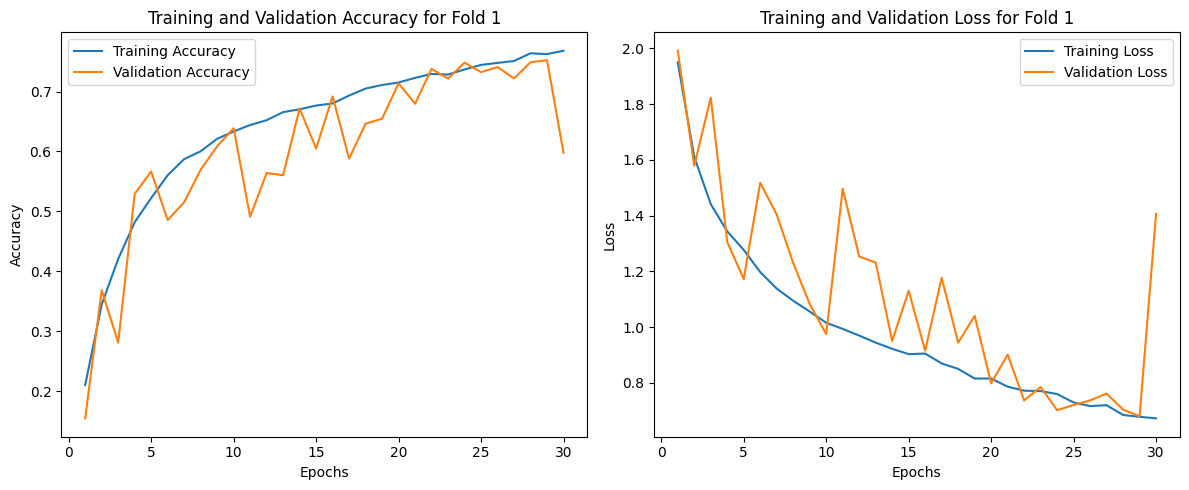

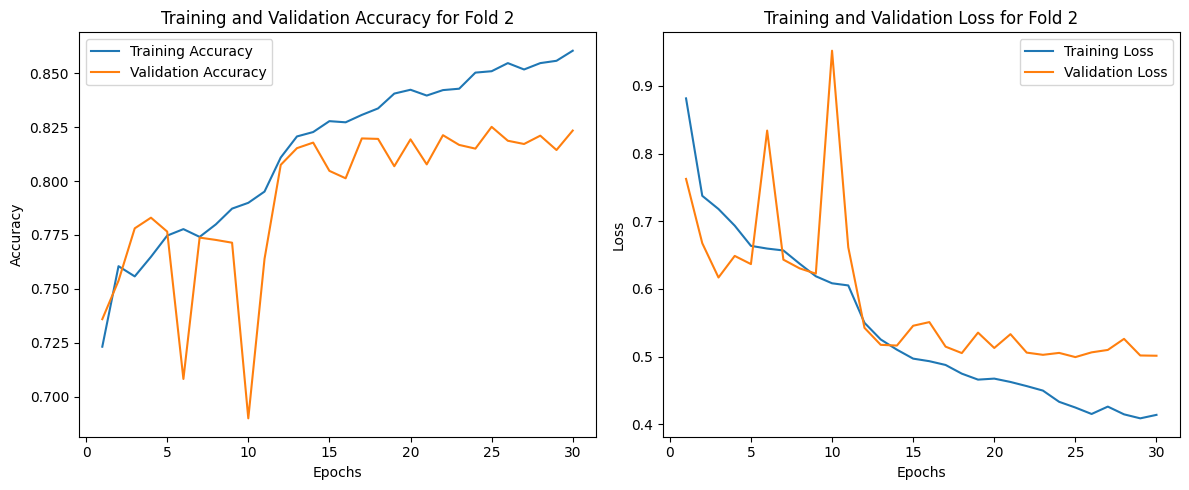

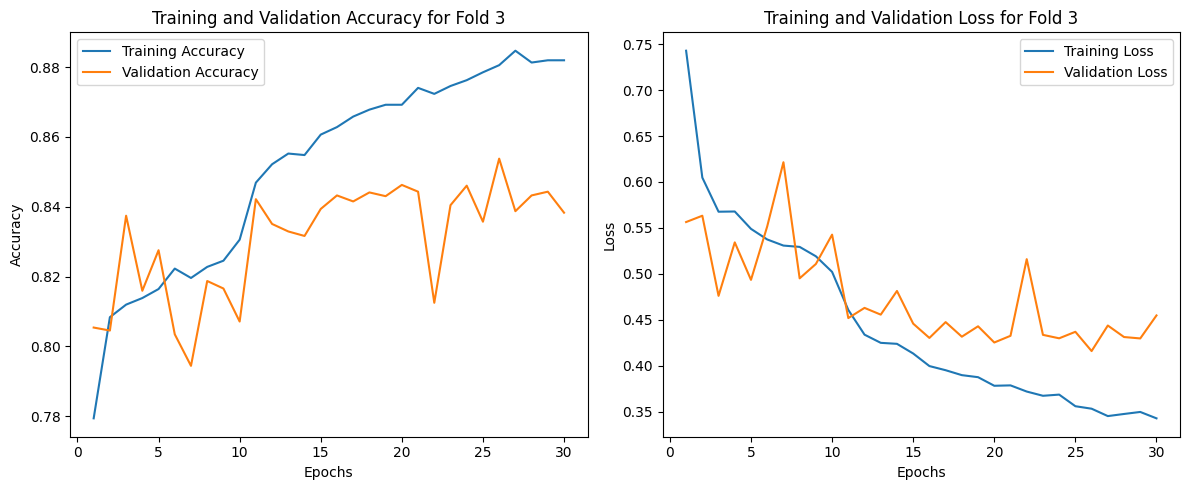

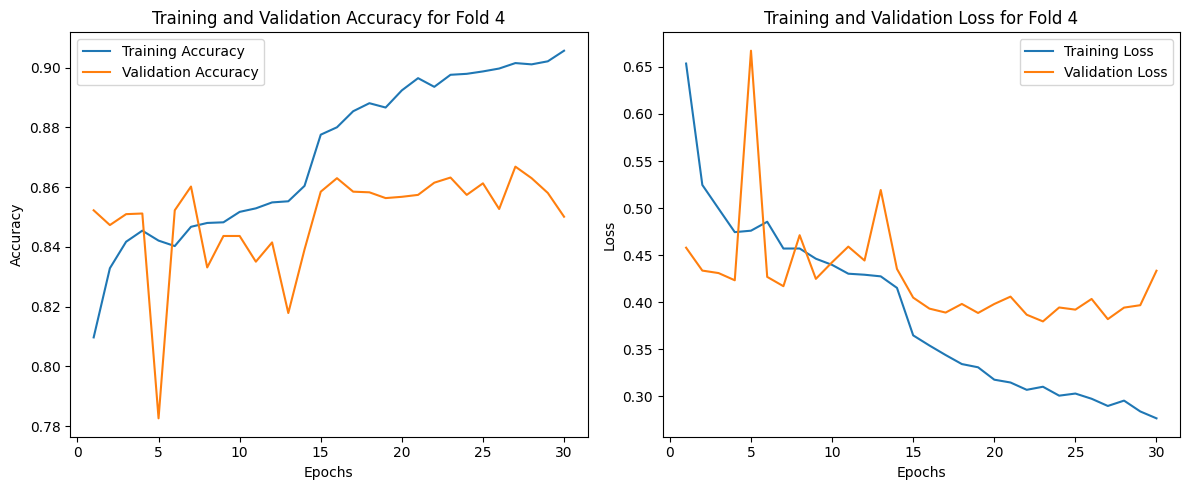

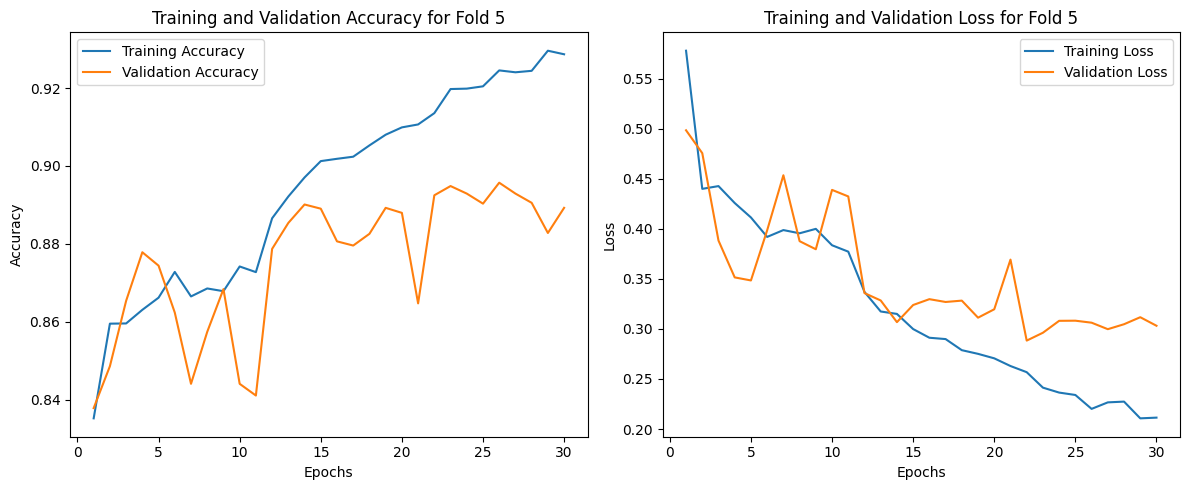

/tmp/ipykernel_34/3089349020.py:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[['Training Accuracy', 'Validation Accuracy']] = df[['Training Accuracy', 'Validation Accuracy']].applymap(lambda x: f'{x:.2f}')


,Fold,Epoch,Training Accuracy,Validation Accuracy
0,1,5,0.52,0.57
1,1,10,0.63,0.64
2,1,15,0.68,0.60
3,1,20,0.72,0.71
4,1,25,0.74,0.73
5,1,30,0.77,0.60
6,2,5,0.77,0.78
7,2,10,0.79,0.69
8,2,15,0.83,0.80
9,2,20,0.84,0.82


In [10]:
# plot training and validation accuracy and loss

data = [] 

for i in range(len(all_train_acc)): # i = fold
    epochs = len(all_train_acc[i])
    
    # to display in table later
    for epoch in range(epochs):
        if (epoch + 1) % 5 == 0:  # Select every 5th epoch
            data.append([i+1, epoch+1, all_train_acc[i][epoch], all_val_acc[i][epoch]])
            
    # to display in graph
    plt.figure(figsize=(12, 5))
    
    # plotting accuracy graph
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), all_train_acc[i], label='Training Accuracy')
    plt.plot(range(1, epochs+1), all_val_acc[i], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy for Fold {i+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # plotting loss graph
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), all_train_loss[i], label='Training Loss')
    plt.plot(range(1, epochs+1), all_val_loss[i], label='Validation Loss')
    plt.title(f'Training and Validation Loss for Fold {i+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
df = pd.DataFrame(data, columns=['Fold', 'Epoch', 'Training Accuracy', 'Validation Accuracy'])
df[['Training Accuracy', 'Validation Accuracy']] = df[['Training Accuracy', 'Validation Accuracy']].applymap(lambda x: f'{x:.2f}')
df.to_csv('training_validation_acc.csv', index=False)
# display dataframe
display(df)

## Evaluation

This is the part where we evaluate the model **using the test set** based on these evaluation metrics: 
1. Accuracy
2. Precision
3. Recall
4. F1 Score
5. Confusion matrix

In [11]:
class_names = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprised']

best_model = tf.keras.models.load_model('/kaggle/working/mobilenet_model.keras')
test_df = pd.read_csv('/kaggle/working/test.csv', dtype={'label': str})

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory = None,
    x_col = 'filename',
    y_col = 'label',
    class_mode = 'categorical',
    target_size = (48, 48),
    batch_size = 32,
    shuffle = False # for testing, keep this to False
)

# make predictions
predictions = best_model.predict(test_generator)
y_pred = np.argmax(predictions, axis = 1) # convert one hot encoding preds to labels
y_true = test_generator.classes

Found 5772 validated image filenames belonging to 7 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  3/181 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step

W0000 00:00:1716743102.450446     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


181/181 ━━━━━━━━━━━━━━━━━━━━ 25s 128ms/step


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')  # or 'micro', 'weighted'
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:\n", report)

Accuracy: 0.8321205821205822
Precision: 0.8334248374580134
Recall: 0.830584797418684
F1 Score: 0.8311962559791067

Classification Report:
               precision    recall  f1-score   support

       Anger       0.80      0.85      0.82       828
     Disgust       0.98      0.97      0.97       841
        Fear       0.92      0.91      0.92       836
       Happy       0.87      0.86      0.86       833
     Neutral       0.67      0.75      0.71       806
         Sad       0.72      0.68      0.70       798
   Surprised       0.87      0.80      0.83       830

    accuracy                           0.83      5772
   macro avg       0.83      0.83      0.83      5772
weighted avg       0.84      0.83      0.83      5772



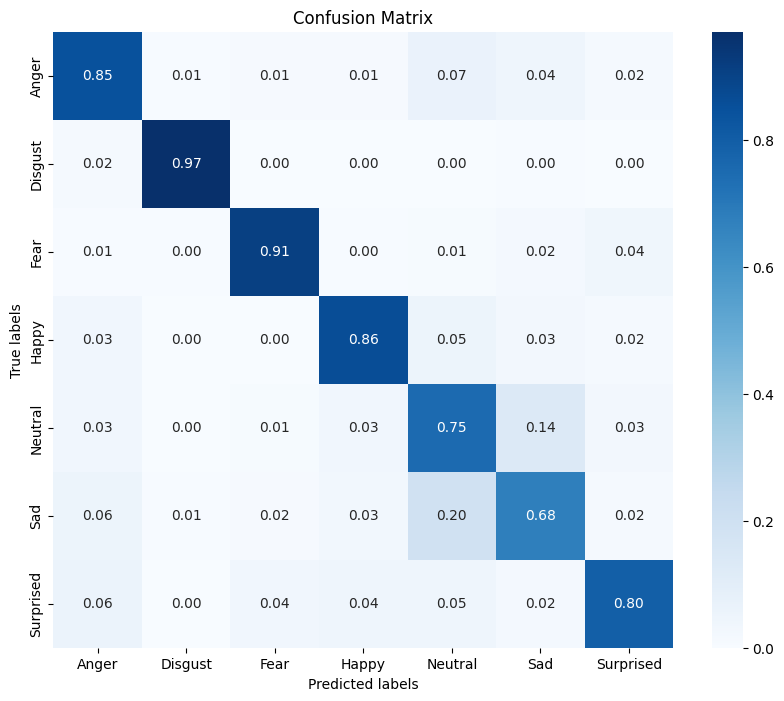

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [14]:
! ls

mobilenet.png	       test.csv   training_validation_acc.csv
mobilenet_model.keras  train.csv  whole_model.png
